In [1]:
#@python 3.8.10
#@author moon ying
#plot continuum membrane results with matplotlib 3d plot and trimesh package
#dependencies are listed as follows

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import trimesh as tr
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import seaborn as sns
sns.set_context("talk")

In [2]:
# INPUT
infile = "vertexfinal.csv" # the input vertex file
num_gags = "796"
gag_infile_id = "1600" # "X" in "SplineX.csv"
z_axis_shift = 50 # recover z-axis shift in model to put z(membrane) @z=0
pdb_name = "~/results/GagR50ComplexPDB/GagR50_796.pdb" #pdb file name

In [3]:
# vertices as pandas.DataFrame
vertices = pd.read_csv(infile, header = None)
vertices.columns = ["x","y","z"]
vertices["z"]-= z_axis_shift
vertices

,x,y,z
0,-89.152028,-90.459550,-1.629201e-08
1,-87.344366,-90.453274,-9.443909e-09
2,-85.536355,-90.446479,-4.465022e-09
3,-83.727869,-90.438879,-1.516341e-09
4,-81.918780,-90.430219,-1.807834e-10
...,...,...,...
11812,83.700000,90.413052,0.000000e+00
11813,85.500000,90.413052,0.000000e+00
11814,87.300000,90.413052,0.000000e+00
11815,89.100000,90.413052,0.000000e+00


In [4]:
# gags as pandas.DataFrame
gags = pd.read_csv("Spline" + gag_infile_id + ".csv", header=None)
gags.columns = ["x", "y", "z"]
gags["z"]-= z_axis_shift
gags

,x,y,z
0,-0.380773,5.239510,23.1262
1,-0.015813,-0.822646,23.3823
2,2.392790,-1.785460,23.2764
3,4.428460,-0.179089,23.1531
4,-0.634351,-3.580110,23.2573
...,...,...,...
791,21.768000,-28.822700,7.6052
792,25.324000,-28.021000,5.7268
793,-40.747500,10.058200,1.2603
794,18.904300,29.337300,9.0278


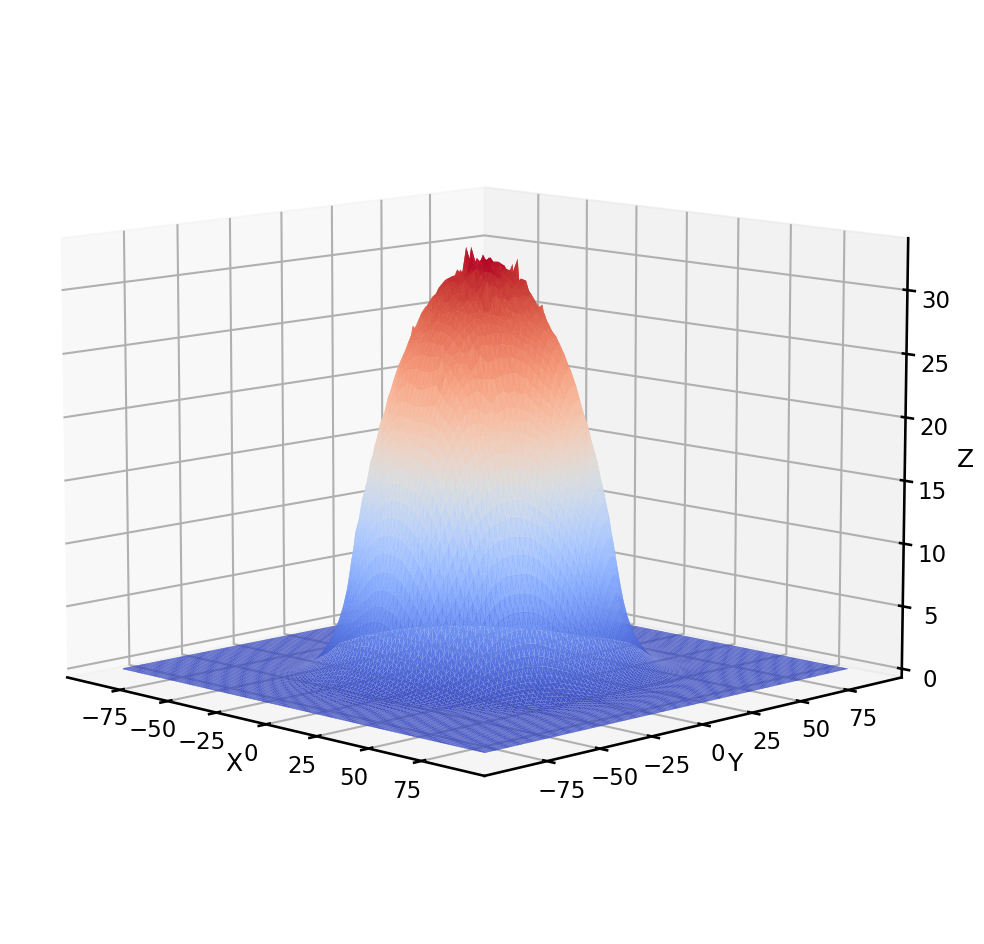

In [5]:
# Simple plot of membrane only
# Z-axis not drawn to scale
# this is for quick checking deformation of the membrane

fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

# Plot the surface.

# uncomment the following line for scatter representation
# ax.scatter3D(vertices["x"], vertices["y"], vertices["z"], c = vertices["z"], s = 16.0);
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# uncomment the following line for triangular surface representation
surf = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], cmap=cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev = 10, azim = -45)
plt.savefig(num_gags + "gags_SurfaceOverview", dpi = 900)

In [6]:
# %%
def read_pdb(filename):
    """
    Read .pdb file from NERDSS output for gag lattices
    and return dataframe with header renamed. Note the
    last two columns are only placeholder for pdb file
    format.

    Args:
        filename (str): file name string

    Returns:
        df (pandas.DataFrame): dataframe of imported pdb
    """
    df = pd.read_csv(filename, skiprows = 3, sep = "\s+", header = None) #"\s+" for undefined number of spaces
    df.columns = ["Type", "Index", "Particle", "Molecule", "Molecule Index", "X", "Y", "Z", "Occupancy", "Atom"]
    return df

# %%
def get_COM_coord(df, drop = True):
    """
    Extract coordinate data (XYZ) of COM from the input
    dataframe based on "Particle" property. .

    Args:
        df (pandas.DataFrame): dataframe of imported pdb
        drop (bool, optional): Drop all other properties 
        except for CoM coordinates when set to drop = True.
        Defaults to True.

    Returns:
        df_COM (pandas.DataFrame): dataframe of imported pdb
        with only CoM coordinate data.
    """
    df_COM = df.loc[df['Particle'] == "COM"].reset_index(drop = True)
    if drop:
        df_COM = df_COM.drop(columns =\
                             ["Type", "Particle", "Index", "Molecule", "Molecule Index", "Occupancy", "Atom"])
    return df_COM

#%%
def is_shorter_than(arraylike1, arraylike2, dist_cutoff):
    """
    Determine if the distance between arraylike1 and arraylike2
    is shorter than dist_cutoff.

    Returns:
        boolean: True if ||arraylike1 arraylike2|| < dist_cutoff
    """
    if ((arraylike1[0] - arraylike2[0]) ** 2 + (arraylike1[1] - arraylike2[1]) ** 2 +\
            (arraylike1[2] - arraylike2[2]) ** 2 < dist_cutoff ** 2):
        return True
    else:
        return False

In [16]:
# This part serves to plot gags as sticks
# the intermolecular and intramolecular bonds are plotted differentially

df = read_pdb(pdb_name)

df_COM = get_COM_coord(df)
COM_COM = np.array([df_COM["X"].mean(), df_COM["Y"].mean(), df_COM["Z"].mean()])
df_gags_r = gags.copy()
df_gags_r.columns = ["X","Y","Z"]
COM_gags_r = np.array([df_gags_r["X"].mean(), df_gags_r["Y"].mean(), df_gags_r["Z"].mean()])

#zero COM for both rotated and unrotated
#unrotated->
df = read_pdb(pdb_name)
df["X"] -= COM_COM[0]
df["Y"] -= COM_COM[1]
df["Z"] -= COM_COM[2]

#rotated->
df_gags_r = gags.copy()
df_gags_r.columns = ["X","Y","Z"]
df_gags_r["X"] -= COM_gags_r[0]
df_gags_r["Y"] -= COM_gags_r[1]
df_gags_r["Z"] -= COM_gags_r[2]

#COM
df_COM = get_COM_coord(df)
df_COM


#https://math.stackexchange.com/questions/158538/3d-transformation-two-triangles
#rotate df_COM to gags_r
gags_r_np = df_gags_r.to_numpy()
df_COM_np = df_COM.to_numpy()
rlist = []

for i in range(1, 2):
    j = i * 3

    cbar = gags_r_np[j:j+3].mean(axis = 0)
    c = df_COM_np[j:j+3].mean(axis = 0)
    ybar = gags_r_np[j:j+3] - cbar
    y = df_COM_np[j:j+3] - c
    H = np.outer(y[0], ybar[0]) + np.outer(y[1], ybar[1]) + np.outer(y[2], ybar[2])
    s, v, d = np.linalg.svd(H)
    R = np.matmul(np.transpose(d), np.transpose(s))
    print(R)
    print(cbar - np.matmul(R, c))
    rlist.append(R)
    

rmat = sum(rlist)/len(rlist)
df[["X","Y","Z"]] = np.transpose(np.matmul(rmat, np.transpose(df[["X","Y","Z"]].to_numpy())))
#recover displacement
df["X"] += COM_gags_r[0]
df["Y"] += COM_gags_r[1]
df["Z"] += COM_gags_r[2]
df.to_csv(num_gags + "full_gags.csv")
df_full_gags = df
df_full_gags_np = df_full_gags[["X","Y","Z"]].to_numpy()

#%
nearbypt_pairlist = []
for i in range(0, int(len(df_full_gags))):
    for j in range(0, i):
        if (is_shorter_than(df_full_gags_np[i], df_full_gags_np[j], 0.9)):
            nearbypt_pairlist.append((i,j))
            #print(f"({i},{j})")


[[ 0.39147026 -0.63085021 -0.66990973]
 [-0.62679482  0.35019653 -0.69605362]
 [ 0.67370564  0.69238024 -0.25832212]]
[-9.27078082e-05  2.89816922e-04  5.62423696e-05]


In [17]:
df_full_gags

,Type,Index,Particle,Molecule,Molecule Index,X,Y,Z,Occupancy,Atom
0,ATOM,1,COM,A,0,-0.380669,5.239223,23.126357,0,0CL
1,ATOM,2,b,A,0,0.631267,4.436922,22.342601,0,0CL
2,ATOM,3,c,A,0,-0.585763,3.827734,24.054914,0,0CL
3,ATOM,4,d,A,0,0.306582,6.037186,21.412137,0,0CL
4,ATOM,5,p,A,0,-0.682277,5.810986,21.415593,0,0CL
...,...,...,...,...,...,...,...,...,...,...
4771,ATOM,4778,b,A,796,39.649888,6.379539,1.116702,0,0CL
4772,ATOM,4779,c,A,796,40.235418,6.120108,3.208376,0,0CL
4773,ATOM,4780,d,A,796,38.857575,7.966619,0.497649,0,0CL
4774,ATOM,4781,p,A,796,38.250040,7.954073,1.309529,0,0CL


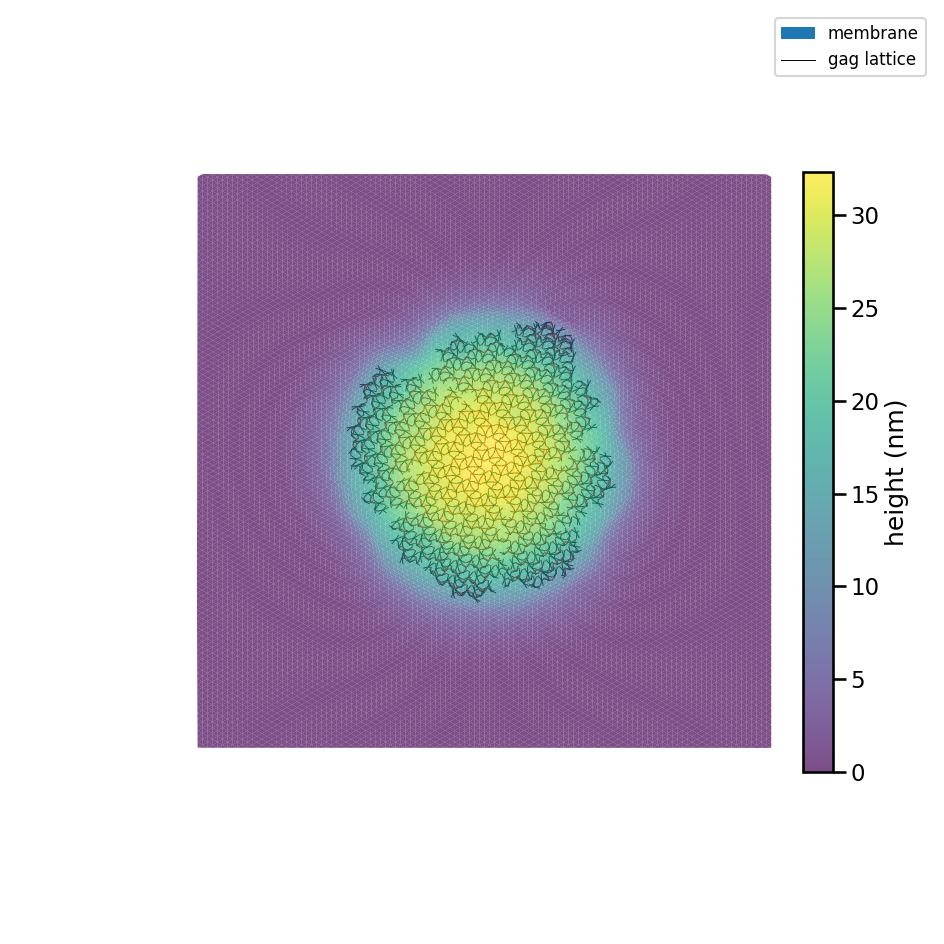

In [18]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.6, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 90, azim = 0)

plt.savefig(num_gags + "gags_stick_membrane_topdown_uniform_zscale.png", dpi = 900)

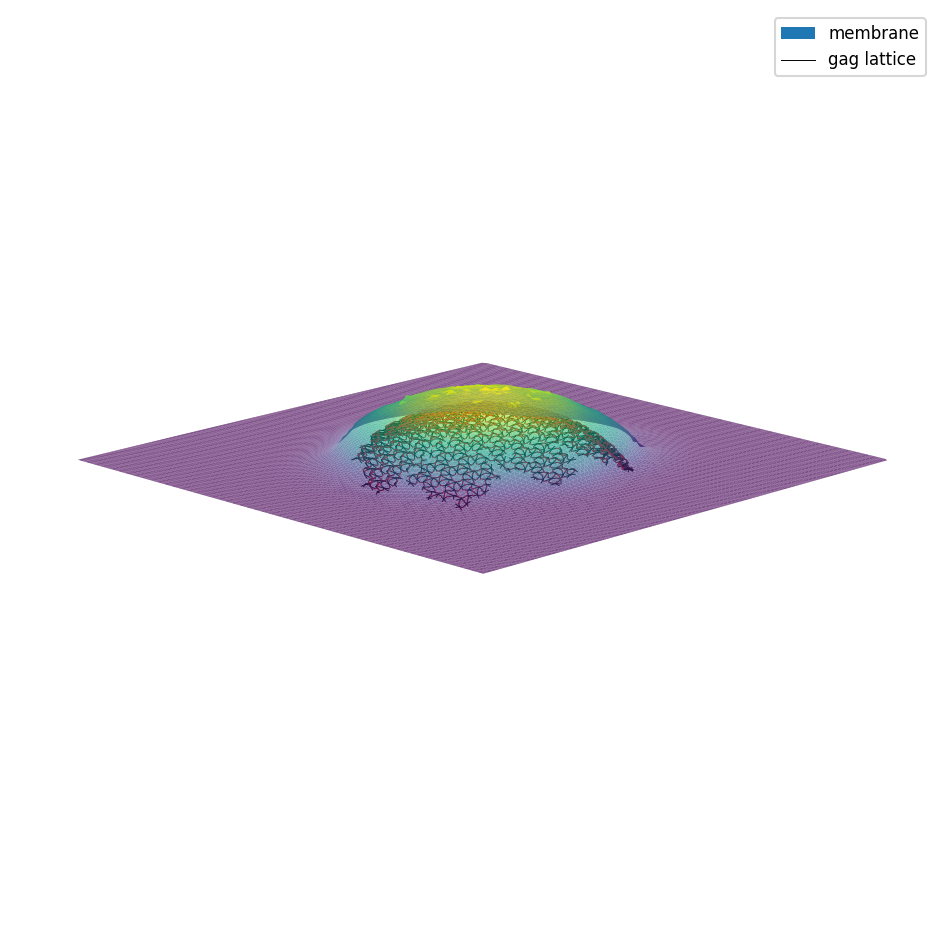

In [19]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

#plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.0, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 15, azim = 45)

plt.savefig(num_gags + "gags_membrane_15deg_uniform_scale.png", dpi = 900)

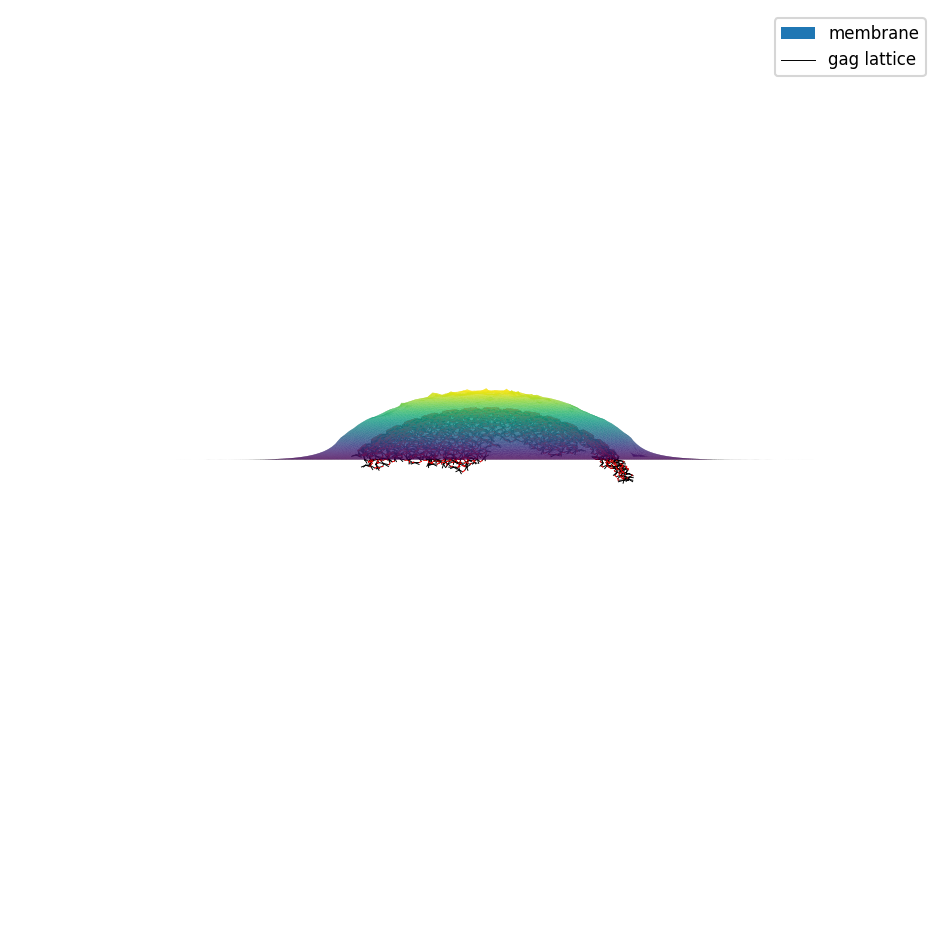

In [20]:
# Plot the surface.

#%
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection='3d')

#surf_gags = ax.plot_trisurf(gags["x"], gags["y"], gags["z"], cmap="Oranges")
surf_vertices = ax.plot_trisurf(vertices["x"], vertices["y"], vertices["z"], \
                                cmap="viridis", alpha = 0.7, label = "membrane")
# https://stackoverflow.com/questions/54994600/pyplot-legend-poly3dcollection-object-has-no-attribute-edgecolors2d
surf_vertices._facecolors2d=surf_vertices._facecolors
surf_vertices._edgecolors2d=surf_vertices._edgecolors

#plt.colorbar(surf_vertices, shrink = 0.65, pad = 0.01, anchor = (-0.0, 0.5), label = "height (nm)")


for i in range(0, int(len(df_full_gags)/6)):
    for j in range(1, 6):
        if (i == 0 and j == 1):
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7, label = "gag lattice")
        else:
            ax.plot([df_full_gags["X"][6 * i], df_full_gags["X"][6 * i + j]],\
                [df_full_gags["Y"][6 * i], df_full_gags["Y"][6 * i + j]],\
                [df_full_gags["Z"][6 * i], df_full_gags["Z"][6 * i + j]], "k", linewidth = 0.7)
for (i, j) in nearbypt_pairlist:
    ax.plot([df_full_gags_np[i][0], df_full_gags_np[j][0]],\
                [df_full_gags_np[i][1], df_full_gags_np[j][1]],\
                [df_full_gags_np[i][2], df_full_gags_np[j][2]], "r", linewidth = 0.7)
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')


ax.set_xlim3d(-90.0, 90.0)
ax.set_ylim3d(-90.0, 90.0)
ax.set_zlim3d(-100.0, 100.0)
ax.set_axis_off()
ax.legend(prop={'size': 12})
ax.view_init(elev = 0, azim = 45)

plt.savefig(num_gags + "gags_membrane_0deg_uniform_scale.png", dpi = 900)

Energy and Force
==

In [12]:
df_ef = pd.read_csv("EnergyForce.csv", index_col = False, header = None, skiprows = 1)
df_ef.columns = ["E_curv", "E_area", "E_reg", "E_total", "F_mean"]
df_ef["E_scaffold"] = df_ef["E_total"] - df_ef["E_curv"] - df_ef["E_area"] - df_ef["E_reg"]
df_ef = df_ef/4.17
df_ef

,E_curv,E_area,E_reg,E_total,F_mean,E_scaffold
0,0.087009,2.942686e-09,6.558921e+00,661688.249400,0.532650,661681.603470
1,2.511271,2.497794e-06,4.281511e+01,661139.088729,0.624014,661093.762348
2,12.596235,6.402662e-05,8.085396e+01,660338.129496,0.640794,660244.679241
3,84.573381,2.954484e-03,2.132513e+02,657983.213429,0.932588,657685.385775
4,145.764029,9.148417e-03,1.666918e+02,656618.705036,0.849513,656306.240012
...,...,...,...,...,...,...
2509,1896.726619,7.085851e+03,1.686868e-14,17531.486811,0.733448,8548.908873
2510,1896.726619,7.085851e+03,5.740216e-16,17531.486811,0.733448,8548.908873
2511,1896.726619,7.085851e+03,1.953173e-17,17531.486811,0.733448,8548.908873
2512,1896.726619,7.085851e+03,2.724029e-19,17531.486811,0.733448,8548.908873


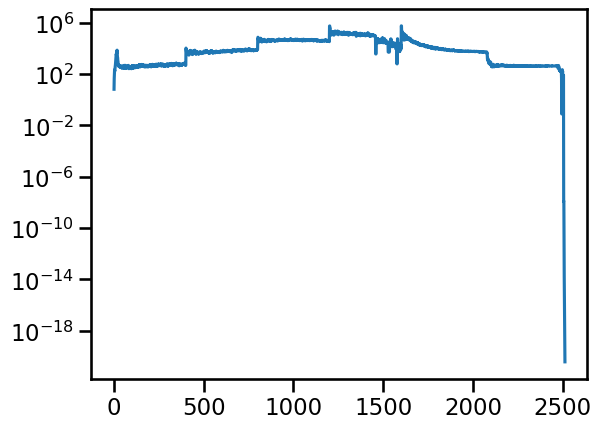

In [13]:
plt.yscale("log")
plt.plot(df_ef["E_reg"])

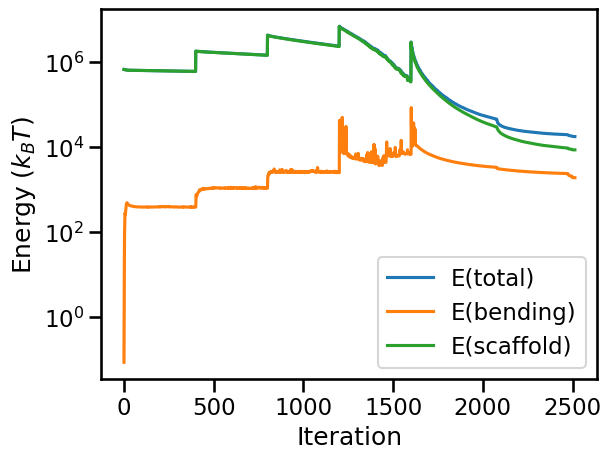

In [14]:
plt.yscale("log")
plt.plot(df_ef["E_total"])
plt.plot(df_ef["E_curv"])
plt.plot(df_ef["E_scaffold"])
plt.xlabel("Iteration")
plt.ylabel("Energy ($k_{B}T$)")
plt.legend(["E(total)", "E(bending)", "E(scaffold)"])
plt.savefig(num_gags + "gags_energyVsIter.png", dpi = 900)

Text(0, 0.5, 'Membrane bending energy ($k_{B}T$)')

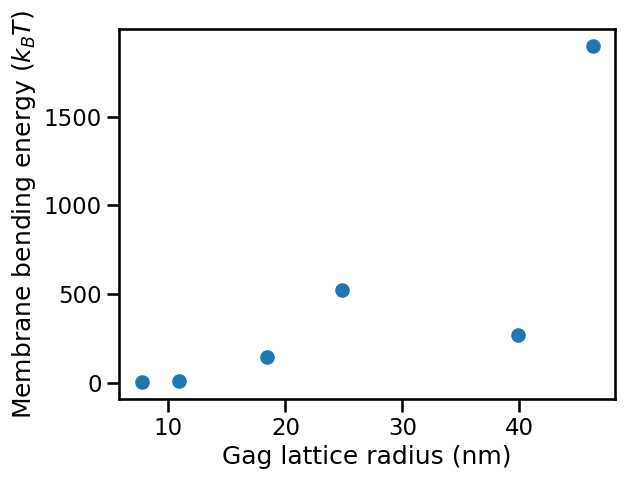

In [22]:
radii = [7.71099601, 10.90499514, 18.45374056, 24.82370271, 32.54933885, 46.26597606]
e_curvs = [1.347472, 6.177722, 144.345803, 523.254197, 268.985612, 1896.726619]

plt.scatter(radii, e_curvs)
plt.xlabel("Gag lattice radius (nm)")
plt.ylabel("Membrane bending energy ($k_{B}T$)")